## Урок 3. Коллаборативная фильтрация

4) Поэкспериментировать с ALS (grid-search)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm
# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from metrics import precision_at_k, recall_at_k

In [2]:
data = pd.read_csv('recsys_retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [3]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

def recall_at_k(recommended_list, bought_list, k):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    recall = flags.sum() / len(bought_list)
    return recall

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [5]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [6]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [8]:
%%time
# базовые параметры
model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 3.4 s


In [9]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [10]:
%%time
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 51.1 s


0.16150832517139846

In [11]:
%%time
list_fac_reg_iters_num_t = []
list_result = []

for fac in tqdm(np.arange(1, 11, 2)):
    for reg in np.arange(0.001, 1, 0.1):
#         for iters in np.arange(1, 11, 2):
#             for num_t in np.arange(1, 5, 2):

        model = AlternatingLeastSquares(factors=fac, 
                                        regularization=0.7,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        num_threads=4)

        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                  show_progress=False)

        recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                                user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                N=5, # кол-во рекомендаций 
                                filter_already_liked_items=False, 
                                filter_items=None, 
                                recalculate_user=True)
        result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        list_result.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
        list_fac_reg_iters_num_t.append(list([fac, 0.7, 15, 4]))
                
        
        

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:31<00:00, 126.37s/it]

Wall time: 10min 31s


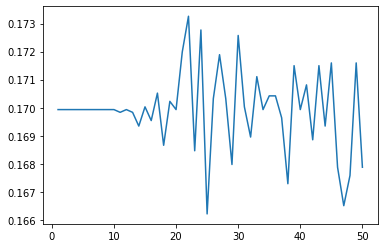

In [12]:
plt.plot(np.arange(1, len(list_result) + 1 ), list_result)

In [13]:
%%time
list_fac_reg_iters_num_t2 = []
list_result2 = []

for fac in tqdm(np.arange(1, 103, 5)):
#     for reg in np.arange(0.001, 1, 0.1):
#         for iters in np.arange(1, 11, 2):
#             for num_t in np.arange(1, 5, 2):

        model = AlternatingLeastSquares(factors=fac, 
                                        regularization=0.7,
                                        iterations=5, 
                                        calculate_training_loss=True, 
                                        num_threads=4)

        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                  show_progress=False)

        recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                                user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                N=5, # кол-во рекомендаций 
                                filter_already_liked_items=False, 
                                filter_items=None, 
                                recalculate_user=True)
        result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        list_result2.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
        list_fac_reg_iters_num_t2.append(list([fac, 0.7, 5, 4]))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [06:49<00:00, 19.48s/it]

Wall time: 6min 49s


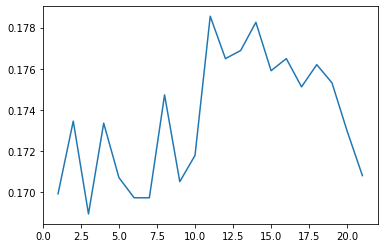

In [14]:
plt.plot(np.arange(1, len(list_result2) + 1 ), list_result2)

In [19]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.7,
                                iterations=5, 
                                calculate_training_loss=True, 
                                num_threads=2)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()



Wall time: 19.6 s


0.17884427032321007

In [16]:
# В результате подбора параметров метрика выросла.

*)  доделать фильтрацию товаров.

In [17]:
def prefilter_items(data: pd.DataFrame, group_col: str=None, popular_col: str=None, time_col: str=None, price_col: str=None,
                    top_popular_filter: int = None, top_unpopular_filter: int = None, time_unpopular_filter: int = None,
                    chip_item_filter: int = None, exp_item_filter: int = None) -> pd.DataFrame:

    n_filter_start = (data_train['item_id'] == 999999).sum()

    if top_popular_filter:  # фильтр самых популярных товаров
        popularity = data_train.groupby(
            group_col)[popular_col].sum().reset_index()
        top = popularity.sort_values(popular_col, ascending=False).head(
            top_popular_filter).item_id.tolist()
        data.loc[data[group_col].isin(top), group_col] = 999999

    if top_unpopular_filter:  # фильтр самых популярных товаров
        bottom = popularity.sort_values(
            popular_col, ascending=True).head(top_unpopular_filter).item_id.tolist()
        data.loc[data[group_col].isin(bottom), group_col] = 999999

    if time_unpopular_filter:  # фильтр товаров, которые не продавались за последние N месяцев
        actuality = data.groupby(group_col)[time_col].min().reset_index()
        top_actual = actuality[actuality[time_col] > 365].item_id.tolist()
        data.loc[data[group_col].isin(top_actual), group_col] = 999999

    if chip_item_filter:  # Фильт товаров, которые стоят < N$
        low_price = data[data[price_col] < chip_item_filter].item_id.tolist()
        data.loc[data[group_col].isin(low_price), group_col] = 999999

    if exp_item_filter:  # Фильт товаров, которые стоят > N$ (дорогих)
        high_price = data[data[price_col] > exp_item_filter].item_id.tolist()
        data.loc[data[group_col].isin(high_price), group_col] = 999999

    n_filter = (data_train['item_id'] == 999999).sum() - n_filter_start
    print(f'Отфильтровано: {n_filter} записей')

    return data

In [18]:
data_train = prefilter_items(data_train, group_col='item_id',
                             popular_col='quantity',
                             time_col='day',
                             price_col='sales_value',
                             top_popular_filter=5,
                             top_unpopular_filter=200,
                             time_unpopular_filter=365,
                             chip_item_filter=1,
                             exp_item_filter=600)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Отфильтровано: 1114680 записей
